##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [219]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [220]:
orig_df = pd.read_csv('C:\\Users\\MatthewEskridgeLT\\Downloads\\LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [221]:
df = pd.read_csv('C:\\Users\\MatthewEskridgeLT\\Downloads\\LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [222]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [223]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [224]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [225]:
pd.set_option('display.max_columns', None)
print(df.head(3))

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   

   VictimCount  
0            0  
1            0  
2            1  


    X: The X coordinate of the event
    Y: The Y coordinate of the event
    OBJECTID: An ID likely for internal use
    Event_Number: An ID likely for internal use
    ReportedOn: The date the event was reported
    Location: The location of the event
    CSZ: County, State, and ZIP code
    Area_Command: The Command Area the event took place in
    Beat: An ID likely for internal use
    OffenseGroup: The group the offense fits in
    CrimeAgainst: The type of victim
    OffenseCategory: The category the offense fits in
    Offense: Description of the offense
    NIBRSOffenseCode: The National Incident Based Reporting System code for the event
    ViolentCrime: Whether or not the crime was violent
    ShootingVictims: Whether or not there were shooting victims
    VictimCount: The number of victims
    Weapons: Weapons used in the event
    Longitude: The longitude coordinate of the event
    Latitude: The latitude coordinate of the event
    DateDif: Date difference from occurance to reporting
    
    Input variables: Latitude, longitude, hour of day, day of week, area of command, crime classification code
    Target variable: Number of persons involved in incident
    
    There are a few outliers in the data that may need to be adjusted for.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [226]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Convert dataframe to numpy arrays
inputs = df[['X', 'Y', 'Time', 'DayOfWeek', 'Area_Command', 'NIBRSOffenseCode']].values
targets = df['VictimCount'].values

# Split data into training and test sets
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
inputs_train = torch.tensor(inputs_train, dtype=torch.float32)
targets_train = torch.tensor(targets_train, dtype=torch.float32).unsqueeze(1)
inputs_test = torch.tensor(inputs_test, dtype=torch.float32)
targets_test = torch.tensor(targets_test, dtype=torch.float32).unsqueeze(1)


# Create TensorDataset objects
train_dataset = TensorDataset(inputs_train, targets_train)
test_dataset = TensorDataset(inputs_test, targets_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Verify the shape of data
for inputs_batch, targets_batch in train_loader:
    print("Shape of input batch:", inputs_batch.shape)
    print("Shape of target batch:", targets_batch.shape)
    break  # Only print the shapes for the first batch


Shape of input batch: torch.Size([32, 6])
Shape of target batch: torch.Size([32, 1])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [227]:
import torch.nn as nn
import torch.optim as optim

# Define the model
model = nn.Sequential(
    nn.Linear(6, 10),  # Input layer: 6 features going into 10 neurons
    nn.ReLU(),  # Activation function
    nn.Linear(10, 10),  # Hidden layer: 10 neurons going into 10 neurons
    nn.ReLU(),  # Activation function
    nn.Linear(10, 1)  # Output layer: 10 neurons going into 1 output neuron
)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
for epoch in range(100):  # Number of epochs
    for inputs_batch, targets_batch in train_loader:
        # Forward pass
        outputs_batch = model(inputs_batch)
        loss = loss_fn(outputs_batch, targets_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate MSE on test data after each epoch
    with torch.no_grad():
        outputs_test = model(inputs_test)
        test_loss = loss_fn(outputs_test, targets_test.view(-1, 1))  # Ensure target tensor has same shape as output tensor
    print(f"Epoch {epoch+1}, Test Loss: {test_loss.item()}")



Epoch 1, Test Loss: 7.215729810417838e+21
Epoch 2, Test Loss: 3.1735100318601026e+20
Epoch 3, Test Loss: 1.3957241284918772e+19
Epoch 4, Test Loss: 6.138457281957724e+17
Epoch 5, Test Loss: 2.6997213087399936e+16
Epoch 6, Test Loss: 1187349480341504.0
Epoch 7, Test Loss: 52220183707648.0
Epoch 8, Test Loss: 2296667963392.0
Epoch 9, Test Loss: 101008498688.0
Epoch 10, Test Loss: 4442398720.0
Epoch 11, Test Loss: 195378768.0
Epoch 12, Test Loss: 8592690.0
Epoch 13, Test Loss: 377903.96875
Epoch 14, Test Loss: 16634.44140625
Epoch 15, Test Loss: 730.5196533203125
Epoch 16, Test Loss: 33.02214050292969
Epoch 17, Test Loss: 2.3631181716918945
Epoch 18, Test Loss: 0.9939218759536743
Epoch 19, Test Loss: 0.9335941076278687
Epoch 20, Test Loss: 0.934381365776062
Epoch 21, Test Loss: 0.9344995617866516
Epoch 22, Test Loss: 0.9337409138679504
Epoch 23, Test Loss: 0.9335542917251587
Epoch 24, Test Loss: 0.9345120787620544
Epoch 25, Test Loss: 0.9340800642967224
Epoch 26, Test Loss: 0.933715701103

The size of the predicted output should be [32, 1]. For architecture I am using a feed forward neural network with 2 layers of neurons (1 hidden layer). The model is learning but seems to stop improving after about 20 epochs.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [237]:
# Define the model
model = nn.Sequential(
    nn.Linear(6, 10),  # Input layer: 6 features going into 10 neurons
    nn.ReLU(),  # Activation function
    nn.Linear(10, 10),  # Hidden layer: 10 neurons going into 10 neurons
    nn.ReLU(),  # Activation function
    nn.Linear(10, 6)  # Output layer: 10 neurons going into 6 output neurons (assuming 6 classes)
)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.3)

# Training loop
for epoch in range(100):  # Number of epochs
    for inputs_batch, targets_batch in train_loader:
        # Forward pass
        outputs_batch = model(inputs_batch)
        targets_batch_indices = torch.argmax(targets_batch, dim=1)  # Convert one-hot encoded targets to class indices
        loss = loss_fn(outputs_batch, targets_batch_indices)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate Accuracy on test data after each epoch
    with torch.no_grad():
        outputs_test = model(inputs_test)
        predicted = torch.argmax(outputs_test.data, dim=1)  # Get predicted classes
        total = targets_test.size(0)
        targets_test_indices = torch.argmax(targets_test, dim=1)  # Convert one-hot encoded targets to class indices
        correct = (predicted == targets_test_indices).sum().item()
        accuracy = correct / total
    print(f"Epoch {epoch+1}, Accuracy: {accuracy}")



Epoch 1, Accuracy: 1.0
Epoch 2, Accuracy: 1.0
Epoch 3, Accuracy: 1.0
Epoch 4, Accuracy: 1.0
Epoch 5, Accuracy: 1.0
Epoch 6, Accuracy: 1.0
Epoch 7, Accuracy: 1.0
Epoch 8, Accuracy: 1.0
Epoch 9, Accuracy: 1.0
Epoch 10, Accuracy: 1.0
Epoch 11, Accuracy: 1.0
Epoch 12, Accuracy: 1.0
Epoch 13, Accuracy: 1.0
Epoch 14, Accuracy: 1.0
Epoch 15, Accuracy: 1.0
Epoch 16, Accuracy: 1.0
Epoch 17, Accuracy: 1.0
Epoch 18, Accuracy: 1.0
Epoch 19, Accuracy: 1.0
Epoch 20, Accuracy: 1.0
Epoch 21, Accuracy: 1.0
Epoch 22, Accuracy: 1.0
Epoch 23, Accuracy: 1.0
Epoch 24, Accuracy: 1.0
Epoch 25, Accuracy: 1.0
Epoch 26, Accuracy: 1.0
Epoch 27, Accuracy: 1.0
Epoch 28, Accuracy: 1.0
Epoch 29, Accuracy: 1.0
Epoch 30, Accuracy: 1.0
Epoch 31, Accuracy: 1.0
Epoch 32, Accuracy: 1.0
Epoch 33, Accuracy: 1.0
Epoch 34, Accuracy: 1.0
Epoch 35, Accuracy: 1.0
Epoch 36, Accuracy: 1.0
Epoch 37, Accuracy: 1.0
Epoch 38, Accuracy: 1.0
Epoch 39, Accuracy: 1.0
Epoch 40, Accuracy: 1.0
Epoch 41, Accuracy: 1.0
Epoch 42, Accuracy: 1.0
E

The number of classes can be identified by using a function to calculate the number of unique outputs, in this case number of victims. With classification the output layer will have multiple neurons one for each class. The cross entropy loss function is used insted of the mean squared error.

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Tasks 3 and 4 were quite the challenge to complete. The results I observed of task 3 were much clearer and do show a continuous trend. Task 3 worked better in my case possibly just because I have a better grasp on regression and am more familiar with how to set up and adjust the neural network.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


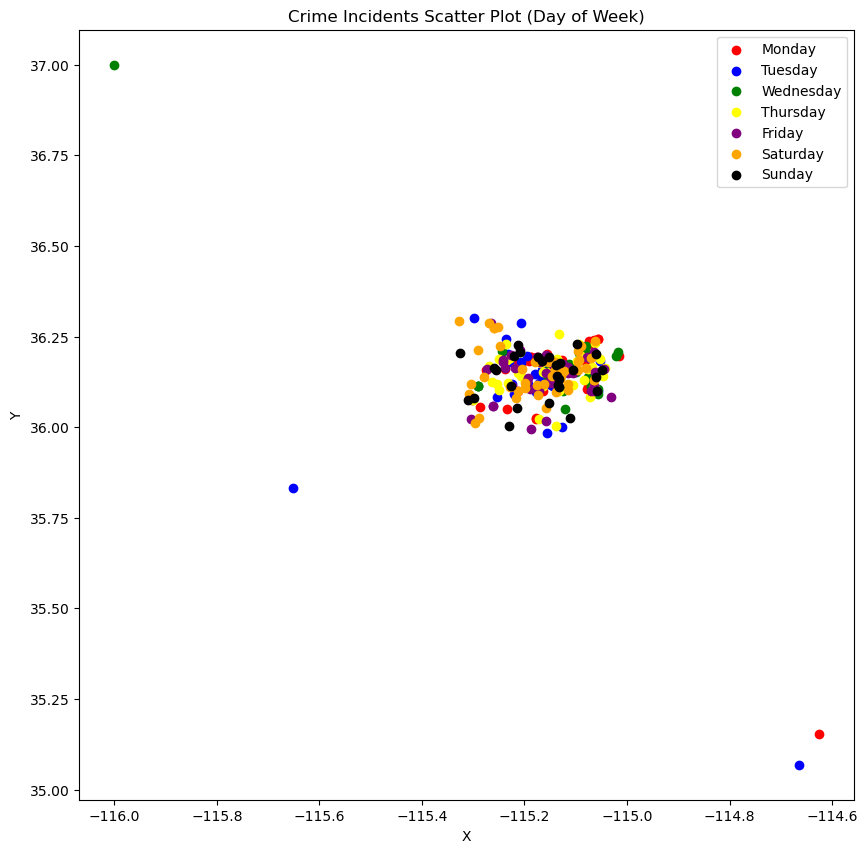

In [232]:
# Color dictionary for each unique day of the week
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'purple', 5:'orange', 6:'black'}

# Label dictionary for each unique day of the week
labels = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

plt.figure(figsize=(10,10))

# Plot each day of the week separately to create a labeled legend
for day in df['DayOfWeek'].unique():
    plt.scatter(df['X'][df['DayOfWeek']==day], df['Y'][df['DayOfWeek']==day], c=colors[day], label=labels[day])

plt.title('Crime Incidents Scatter Plot (Day of Week)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


There are some very rough patterns but nothing stands out as especially significant. For example, on Tuesdays almost all of the cases seem to happen towards the West, but they are not tightly grouped or focused around one specific point. There are also 4 cases that are quite far and possibly should be reported in another database instead

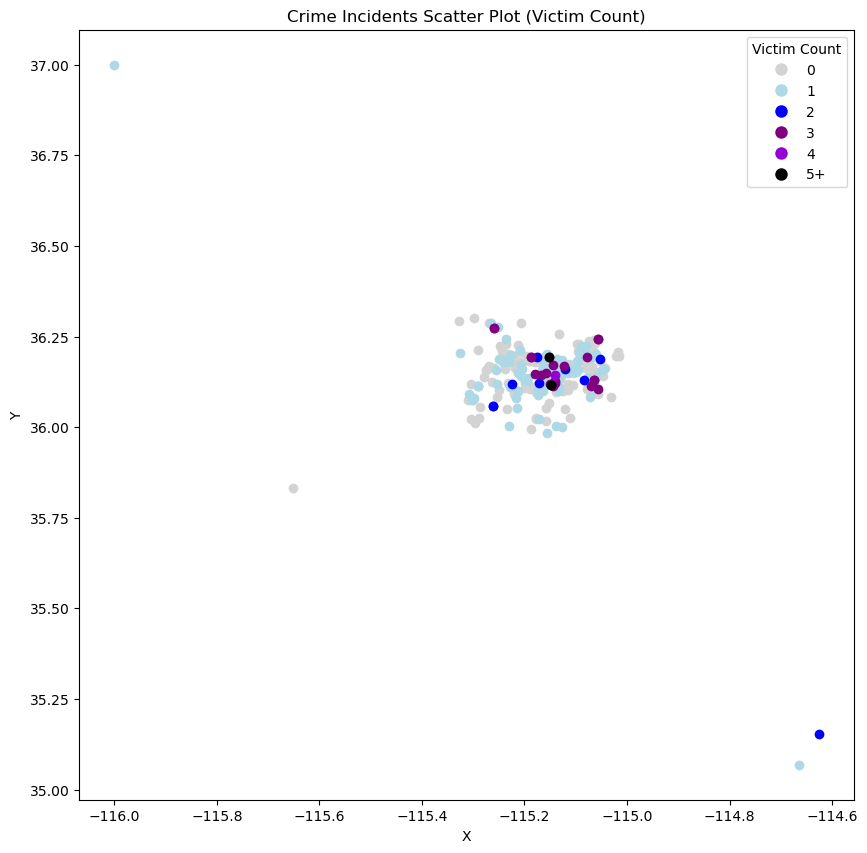

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# Color dictionary for each unique victim count
colors = {0:'lightgray', 1:'lightblue', 2:'blue', 3:'purple', 4:'darkviolet', 5:'black'}

# Label dictionary for each unique victim count
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5+'}

plt.figure(figsize=(10,10))

# Plot each victim count separately
for count in np.sort(df['VictimCount'].unique()):
    if count > 4: # Group all counts of 5 and above together
        plt.scatter(df['X'][df['VictimCount']>=5], df['Y'][df['VictimCount']>=5], c=colors[5])
    else:
        plt.scatter(df['X'][df['VictimCount']==count], df['Y'][df['VictimCount']==count], c=colors[count])

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                          markerfacecolor=colors[i], markersize=10) for i in colors]
plt.legend(handles=legend_elements, title="Victim Count")

plt.title('Crime Incidents Scatter Plot (Victim Count)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


The patterns visible on this graph are quite fascinating. While cases with 1 or less victims are quite spread out, the cases with more victims seem to be a little more tightly grouped towards the city center.

In [233]:
df['DayOfWeek'].value_counts().sort_values(ascending=False)

4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: DayOfWeek, dtype: int64

Day 4 (Thursday) is most common, followed by Day 3 (Wednesday) and Day 5 (Friday). Saturday would appear to be the least common.